In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.io as sio
from statsmodels.tsa.ar_model import AR
from scipy.stats import gaussian_kde
from scipy import signal
from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans,KShape,GlobalAlignmentKernelKMeans,silhouette_score
from tslearn.metrics import dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw,cdist_soft_dtw_normalized
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter,euclidean_barycenter
from sklearn.manifold import MDS,TSNE,SpectralEmbedding


In [2]:
result_path='/home/zoro/Desktop/simulation/results/'

In [3]:
tgfm=0
am=0.1
vm=2
Kvm=8
dm=1
mm=3.8
Kmm=2.4

tgfv=0
av=0.12
mv=1
Kmv=8
dv=1
vv=4
Kvv=2.4

In [4]:
def grad_xy(x,y,delta_t):
    delta_x=delta_t*(tgfm+am+vm*y**2/(y**2+Kvm**2)+mm*x**4/(x**4+Kmm**4)-dm*x)
    delta_y=delta_t*(tgfv+av+mv*x**2/(x**2+Kmv**2)+vv*y**4/(y**4+Kvv**4)-dv*y)
    return delta_x,delta_y

In [5]:
#-----generate traj initials-------
traj_inis=[]
for i in range(300):
    x0=5*np.random.rand()
    y0=5*np.random.rand()
    delta_t=0.01
    st=0
    dur_t=100
    x=x0
    y=y0
    while st<dur_t:
        delta_x,delta_y=grad_xy(x,y,delta_t)
        wn=np.random.normal(scale=1,size=2)

        x+=delta_x+np.sqrt(delta_t)*wn[0]
        y+=delta_y+np.sqrt(delta_t)*wn[1]
        st+=delta_t
    
    traj_inis.append([x,y])
traj_inis= np.array(traj_inis)

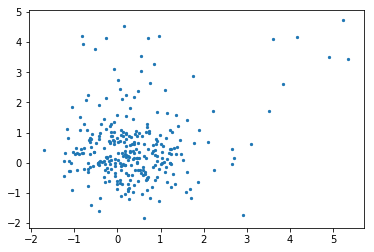

In [6]:
plt.scatter(traj_inis[:,0],traj_inis[:,1],s=5)
plt.show()

# sns.kdeplot(traj_inis[:,0],traj_inis[:,1],shade=True)
# plt.show()

In [7]:
def cross_corr_delay(reaction_traj,d1=0,d2=1):
    n=reaction_traj.shape[0]
    y1=reaction_traj[:,d1]
    y2=reaction_traj[:,d2]
    corr0 = signal.correlate(y1, y2, mode='full') / np.sqrt(np.correlate(y1, y1)*np.correlate(y2, y2))

    corr_range=n//2
    corr=corr0[(n-corr_range)+1:corr_range+n]

#                 corr=abs(corr)
    if np.argmax(corr)>=corr_range:
        print('vim first',np.argmax(corr)-corr_range)

        cc_lag=np.argmax(corr)-corr_range
        max_corr=corr[np.argmax(corr)]
    else:
        print('morph first',-(corr_range-np.argmax(corr)))
        cc_lag=-(corr_range-np.argmax(corr))
        max_corr=corr[np.argmax(corr)]
    return cc_lag,max_corr

In [8]:
#-----generate initial path-------
tgfm=0.6
tgfv=1.0
xf=4.9
yf=5.2

delta_t=0.01
dur_t=20
ini_paths=[]
all_reaction_traj=[]
cut_reaction_traj=[]
cross_corr_lag=[]
for k in range(len(traj_inis)):
    print(k)
    x0=traj_inis[k][0]
    y0=traj_inis[k][1]
    
    if x0<1 and y0<1:

        traj=[]
        wn_traj=[]
        x=x0
        y=y0
        traj.append([x0,y0])
        wn_traj.append([0,0])

        trans_in=0
        trans_out=0
        st=0
        
        
        while st<dur_t:
          
            
            delta_x,delta_y=grad_xy(x,y,delta_t)
    #         print(x,y,delta_x/delta_t,delta_y/delta_t)
            wn=np.random.normal(scale=1,size=2)

            x+=delta_x+np.sqrt(delta_t)*wn[0]
            y+=delta_y+np.sqrt(delta_t)*wn[1]
            st+=delta_t
            traj.append([x,y])
            wn_traj.append(wn)
            if np.sqrt((x-xf)**2+(y-yf)**2)<1:
                trans_in=1
                trans_in_t=int(st/delta_t)
            if trans_in==1 and trans_out==0 and np.sqrt((x-xf)**2+(y-yf)**2)>1:
                trans_out=1
                break

        if trans_in==1 and trans_out==1:
            traj= np.array(traj)
            wn_traj=np.array(wn_traj)
            cut_traj=traj[:trans_in_t,:]
#             dot_color=np.arange(traj.shape[0])
#             plt.scatter(traj[:,0],traj[:,1],s=3,c=dot_color,cmap=plt.cm.jet)
#             plt.colorbar()
#             plt.show()
#             cc_lag,max_corr=cross_corr_delay(traj[::4,:],d1=0,d2=1)

#             cc_lag,max_corr=cross_corr_delay(traj[::4,:]-np.mean(traj[:12,:],axis=0),d1=0,d2=1)
#             cross_corr_lag.append([cc_lag,max_corr])

            cut_reaction_traj.append(cut_traj[::4,:])
            all_reaction_traj.append(traj[::4,:])
            ini_paths.append(np.column_stack((traj[::4,:],wn_traj[::4,:])))
#             ar1_t=ar1_tipping_time(traj)
#             print(ar1_t)
#             wd_size=72
#             Ic=traj_cs_index(traj,size=wd_size,step=1)
#             transition_t.append(np.argmax(Ic[:,0]))
#             critical_points.append(np.mean(traj[np.argmax(Ic[:,0]):np.argmax(Ic[:,0])+wd_size,:],axis=0))


        
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[1.46460296 2.70100253]
morph first -56
0.5629286948296717
vim first 8
0.6465170058204608
morph first -2
0.8879104001660018
vim first 42
0.27999225375693393
morph first -54
0.2679287578618141
vim first 80
0.5270506219030372
vim first 47
0.39568254135997905
morph first -2
0.575484902378133
vim first 30
0.7180307613883318
vim first 1
0.7046605181802289
morph first -2
0.6306100156195728
vim first 73
0.6395642670900895
vim first 30
0.4873996301000894
morph first -95
0.19532245165338885
morph first -90
0.1251515232412117
vim first 7
0.5646470551595125
morph first -61
0.03544117161907708
morph first -2
0.36033361484976606
vim first 27
0.7766484364551082
vim first 46
0.6528120220691714
morph first -2
0.7865819519835325
morph first -43
0.29917423310821256
vim first 64
0.7060450855693756
morph first -2
0.8337373646789342
morph first -2
0.6684822492494329
morph first -2
0.6744648376296161
morph first -12
0.5003033307778831
vim first 30
0.586654212211592
vim first 69
0.5994365388641908
morph firs

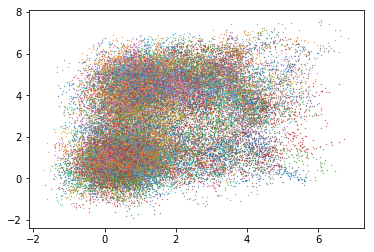

In [9]:
mean_v=np.mean(np.vstack(all_reaction_traj),axis=0)
print(mean_v)

cross_corr_lag=[]
for l in range(len(all_reaction_traj)):
    traj=all_reaction_traj[l][:,:2]
#     dot_color=np.arange(traj.shape[0])
    plt.scatter(traj[:,0],traj[:,1],s=0.1)
#     plt.colorbar()
    cc_lag,max_corr=cross_corr_delay(traj-mean_v,d1=0,d2=1)
    print(max_corr)
    cross_corr_lag.append([cc_lag,max_corr])
plt.show()


(185, 2)


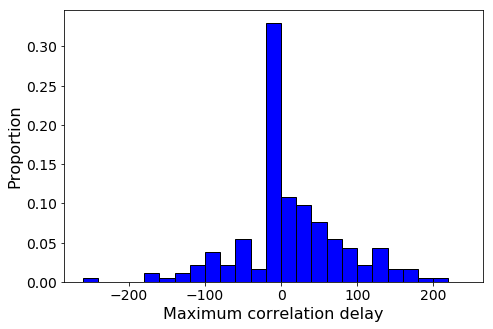

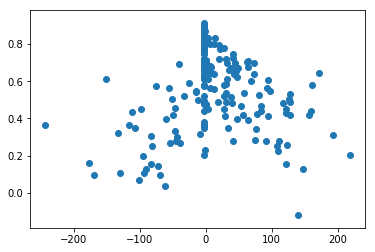

89
95


In [61]:
cross_corr_lag=np.array(cross_corr_lag)
print(cross_corr_lag.shape)
weights = np.ones_like(cross_corr_lag[:,0])/float(len(cross_corr_lag))
plt.figure(figsize=(7.5,5))
bins=np.arange(-260,250,20)
plt.hist(cross_corr_lag[:,0],bins=bins,weights=weights,color='blue',edgecolor='black')
plt.xlabel('Maximum correlation delay',fontsize=16)
plt.ylabel('Proportion',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'simu_cross_corr_lag.png',dpi=300)
plt.show()
# weights = np.ones_like(cross_corr_lag[:,1])/float(len(cross_corr_lag))
# plt.hist(cross_corr_lag[:,1],bins=15,weights=weights)
# plt.xlabel('correlation',fontsize=16)
# plt.show()

plt.scatter(cross_corr_lag[:,0],cross_corr_lag[:,1])
plt.show()

traj_cl_1=[]
traj_cl1=[]
for l in range(len(all_reaction_traj)):
    traj=all_reaction_traj[l]
    if cross_corr_lag[l,0]>0:
        traj_cl1.append(traj)

    if cross_corr_lag[l,0]<0:

        traj_cl_1.append(traj)
print(len(traj_cl1))
print(len(traj_cl_1))

In [39]:
X=to_time_series_dataset(cut_reaction_traj)

In [40]:
km_dba = TimeSeriesKMeans(n_clusters=2, metric="softdtw", max_iter=10,max_iter_barycenter=10,random_state=0).fit(X)
Y=km_dba.labels_

1507837.828 --> 15832.216 --> 7521.587 --> 7206.260 --> 7168.373 --> 7204.624 --> 7188.520 --> 7187.103 --> 7185.364 --> 7184.139 --> 


In [41]:
traj_cl1=[]
traj_cl_1=[]
for i in range(len(all_reaction_traj)):
    if Y[i]==0:
        traj_cl1.append(all_reaction_traj[i])
    else:
        traj_cl_1.append(all_reaction_traj[i])

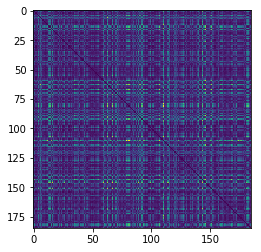

In [14]:
sct_cdist=cdist_soft_dtw_normalized(X)
np.save(result_path+'sct_soft_cdist.npy',sct_cdist)

plt.imshow(sct_cdist)
plt.show()

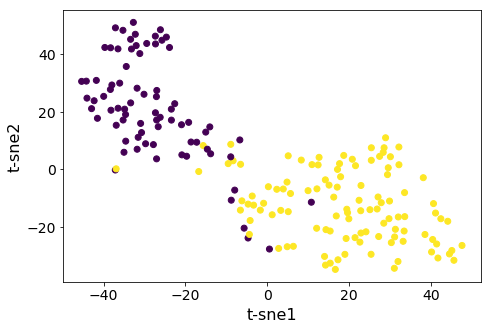

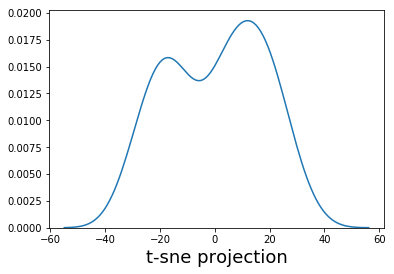

In [57]:
tsne = TSNE(n_components=2, perplexity=5.0, metric='precomputed')
Y = tsne.fit_transform(sct_cdist)
plt.subplots(figsize=(7.5,5))

plt.scatter(Y[:,0],Y[:,1],c=km_dba.labels_)

plt.xlabel('t-sne1',fontsize=16)
plt.ylabel('t-sne2',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'traj_cluster_tsne.png',dpi=300)
plt.show()
tsne = TSNE(n_components=1, perplexity=5.0,metric='precomputed')
Y1 = tsne.fit_transform(sct_cdist)

sns.kdeplot(Y1[:,0])
plt.xlabel('t-sne projection',fontsize=18)
plt.show()

89
536833780.925 --> 585564384.658 --> 585591367.150 --> 585591614.123 --> 585591631.444 --> 585591616.262 --> 585591615.002 --> 585591614.814 --> 585591614.726 --> 585591614.726 --> 
91


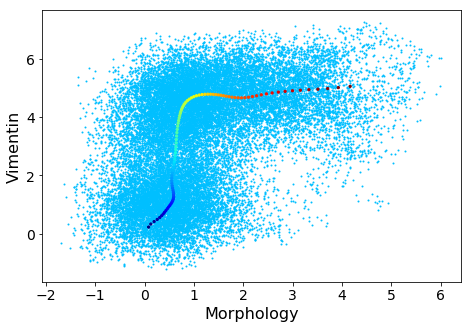

In [48]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
f, ax = plt.subplots(figsize=(7.5,5))
# points = ax.scatter(np.vstack(traj_cl1)[:,0], np.vstack(traj_cl1)[:,1], \
#                     c=np.concatenate(traj_cl1_proba)[:,1], s=1, cmap=cmap)
# f.colorbar(points)
ax.scatter(np.vstack(traj_cl1)[:,0], np.vstack(traj_cl1)[:,1],s=1,color='deepskyblue')
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.axis('equal')




x1=to_time_series_dataset(traj_cl1)
print(len(x1))
#x1_dba=dtw_barycenter_averaging(x1,max_iter=20)
# x1_dba=softdtw_barycenter(x1,gamma=5)
# x1_dba=euclidean_barycenter(x1)
km = TimeSeriesKMeans(n_clusters=1, metric="softdtw",metric_params={"gamma_sdtw": 100},verbose=True).fit(x1)
# ks= KShape(n_clusters=1, verbose=True).fit(x1)
x1_dba=km.cluster_centers_[0]

print(x1_dba.shape[0])
dot_c=np.arange(x1_dba.shape[0])/6
cm=plt.cm.get_cmap('jet')
plt.scatter(x1_dba[:,0].ravel(),x1_dba[:,1].ravel(), c=dot_c,cmap=cm,s=5)
plt.xlabel('Morphology',fontsize=16)
plt.ylabel('Vimentin',fontsize=16)
# plt.axis([-5,15,-5,9])
# cbar=plt.colorbar(ticks=np.arange(0,x1_dba.shape[0]//6,12))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'dtw_traj_cluster1.png',dpi=300)
plt.show()

# np.save(result_path+'traj_cluster1_mean.npy',x1_dba)
# sio.savemat(result_path+'traj_cluster1_mean.mat', {'arr': x1_dba.T})

95
79550902.339 --> 109345214.178 --> 109342260.721 --> 109341856.655 --> 109341643.369 --> 109341651.165 --> 109341626.046 --> 109341626.750 --> 109341624.156 --> 109341624.223 --> 109341624.223 --> 


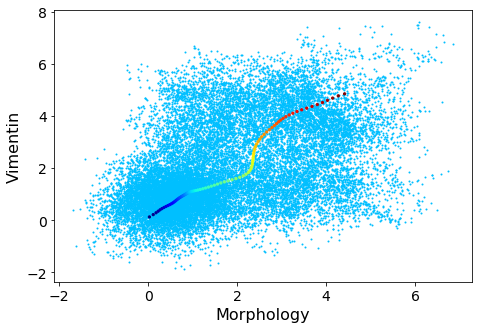

In [49]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
f, ax = plt.subplots(figsize=(7.5,5))
# points = ax.scatter(np.vstack(traj_cl_1)[:,0], np.vstack(traj_cl_1)[:,1], \
#                     c=np.concatenate(traj_cl_1_proba)[:,1], s=1, cmap=cmap)
# f.colorbar(points)
ax.scatter(np.vstack(traj_cl_1)[:,0], np.vstack(traj_cl_1)[:,1],s=1,color='deepskyblue')
# plt.xlabel('Morphology',fontsize=16)
# plt.ylabel('Vimentin',fontsize=16)
# plt.axis('equal')


x_1=to_time_series_dataset(traj_cl_1)
print(len(x_1))
# x_1_dba=dtw_barycenter_averaging(x_1,max_iter=20)
# x_1_dba=softdtw_barycenter(x_1,gamma=1,max_iter=100)
# x_1_dba=euclidean_barycenter(x_1)
km = TimeSeriesKMeans(n_clusters=1, metric="softdtw",metric_params={"gamma_sdtw": 50},verbose=True).fit(x_1)
# # ks= KShape(n_clusters=1, verbose=True).fit(x_1)
x_1_dba=km.cluster_centers_[0]


dot_c=np.arange(x_1_dba.shape[0])
cm=plt.cm.get_cmap('jet')
plt.scatter(x_1_dba[:,0].ravel(),x_1_dba[:,1].ravel(), c=dot_c,cmap=cm,s=5)
plt.xlabel('Morphology',fontsize=16)
plt.ylabel('Vimentin',fontsize=16)
# plt.axis([-5,15,-5,9])
# plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'dtw_traj_cluster2',dpi=300)
plt.show()

# np.save(result_path+'traj_cluster2_mean.npy',x_1_dba)
# sio.savemat(result_path+'traj_cluster2_mean.mat', {'arr': x_1_dba.T})

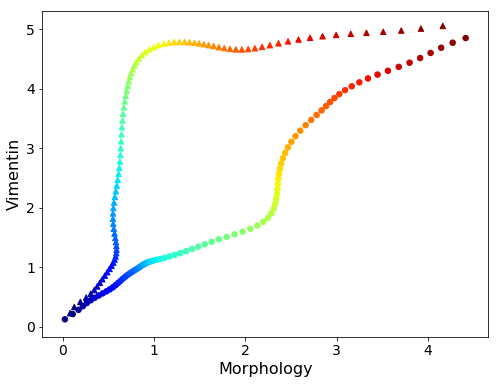

In [51]:
dot_c1=np.arange(x1_dba.shape[0])
dot_c2=np.arange(x_1_dba.shape[0])
cm1=plt.cm.get_cmap('jet')

plt.figure(figsize=(8,6))
plt.scatter(x1_dba[:,0],x1_dba[:,1],c=dot_c1,cmap=cm1,marker='^',s=30,label='vimentin varies first')
plt.scatter(x_1_dba[:,0],x_1_dba[:,1],c=dot_c2,cmap=cm1,s=30,label='morphology varies first')

# cm2=plt.cm.get_cmap('cool')
# plt.scatter(x_1_dba[:,0],x_1_dba[:,1],c=dot_c,cmap=cm1,s=5)
plt.xlabel('Morphology',fontsize=16)
plt.ylabel('Vimentin',fontsize=16)
# lgnd=plt.legend(['morphology varies first','vimentin varies first'],fontsize=12)
# lgnd=plt.legend(fontsize=14)
# lgnd.legendHandles[0]._sizes = [60]
# lgnd.legendHandles[1]._sizes = [60]
# plt.axis([-2.5,3.5,-2.5,2.5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'ccr_mean_path.png',dpi=300)
plt.show()